In [1]:
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
# Set some Pandas options
pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 25)


In [40]:
features = pd.read_csv('constituents-financials_csv.csv', sep=',')
features['Price/Book'] = features['Price/Book'].fillna(features['Price/Book'].mean())
P_B = features['Price/Book'].to_numpy()



/home/elizabeth/labs/labs_venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Max value =  1403.38 , min value = 0.51


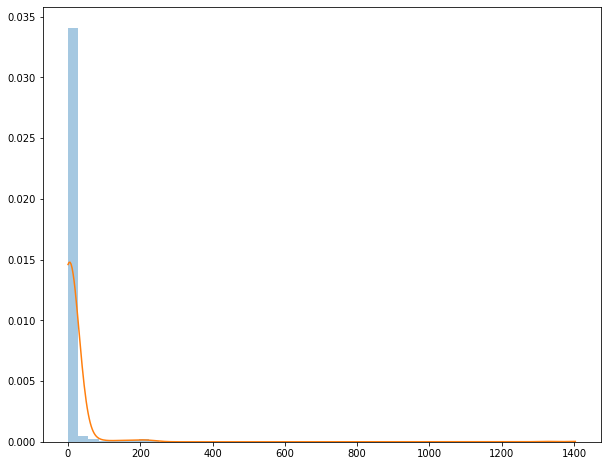

In [4]:
plt.figure(figsize=(10, 8))

kernel = scipy.stats.gaussian_kde(P_B)

min_P_B, max_P_B = P_B.min(), P_B.max()
x = np.linspace(min_P_B, max_P_B, len(P_B))
kde_values = kernel(x)

sns.distplot(P_B, kde=False, norm_hist=True, label=f'Price/Book ratio')
plt.plot(x, kde_values)


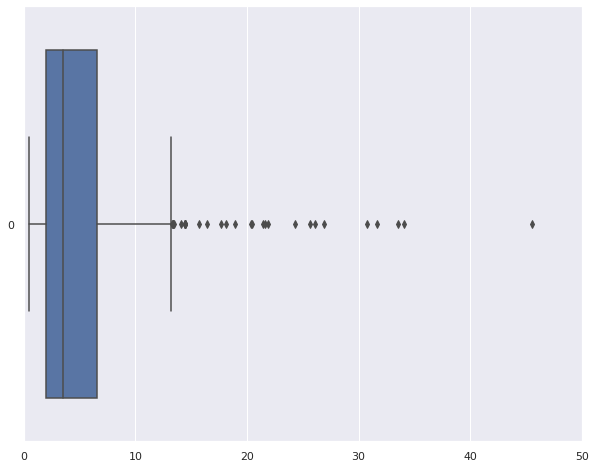

In [43]:
sns.set(rc={'figure.figsize':(10, 8)})
a = sns.boxplot(data=P_B, orient='h')
a.set(xlim=(0, 50))
plt.savefig('boxplot2.png')

In [45]:
Q1, Q3 = features['Price/Book'].quantile([0.25,0.75])
right_whisker = Q3 + 1.5*(Q3-Q1)
left_whisker = Q1 - 1.5*(Q3-Q1)
print ('1/4 qauntile = ', Q1, ' 3/4 qauntile = ' , Q3, 'IQR = ', np.abs(Q1-Q3))
print ('Medain = ', np.median(P_B))

1/4 qauntile =  2.04  3/4 qauntile =  6.53 IQR =  4.49
Medain =  3.49


In [44]:
Left_trim = (np.count_nonzero(P_B < left_whisker, axis=0))/P_B.shape[0]
P_B_trimmed = scipy.stats.trim1(P_B, Left_trim, 'left')
Right_trim = (np.count_nonzero(P_B > right_whisker, axis=0)) /P_B_trimmed.shape[0]
P_B_trimmed = scipy.stats.trim1(P_B_trimmed, Right_trim, 'right')
print(f'max_P/E ratio ', np.max(P_B), ' min_P/E ratio ', np.min(P_B))
print(f'max trimmed P/B ratio ', np.max(P_B_trimmed),
      ' min trimmed P/B ratio ', np.min(P_B_trimmed))

max_P/E ratio  1403.38  min_P/E ratio  0.51
max trimmed P/B ratio  13.24  min trimmed P/B ratio  0.51


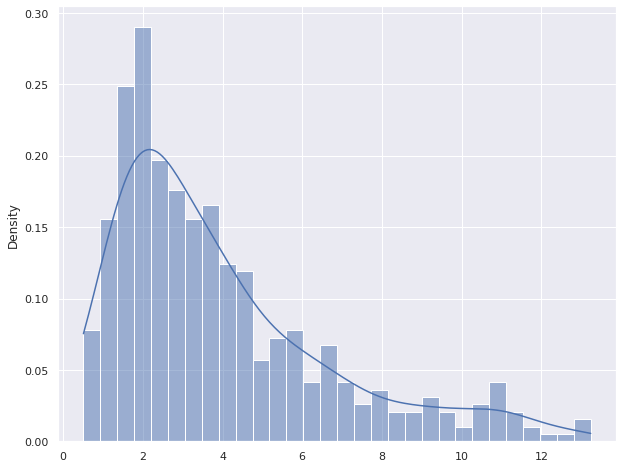

<Figure size 720x576 with 0 Axes>

In [46]:
plt.figure(figsize=(10, 8))
sns.histplot(P_B_trimmed, kde=True, bins=30, stat='density', label=f'Price/Book ratio')
plt.show()
plt.savefig('P_B_trimmed.png')

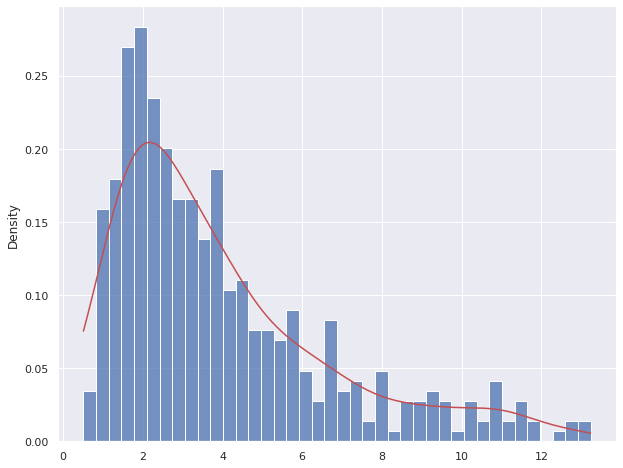

In [47]:
plt.figure(figsize=(10, 8))
kernel = scipy.stats.gaussian_kde(P_B_trimmed)
print(kernel)
min_amount, max_amount = min(P_B_trimmed), max(P_B_trimmed)
x = np.linspace(min_amount, max_amount, len(P_B_trimmed))
kde_values = kernel(x)

sns.histplot(P_B_trimmed, kde=False, bins=40, stat='density', label=f'P/B')
plt.plot(x, kde_values, color='r')

(0.7209171120905734, 0.17596983303993463, 2.9498064783141063)


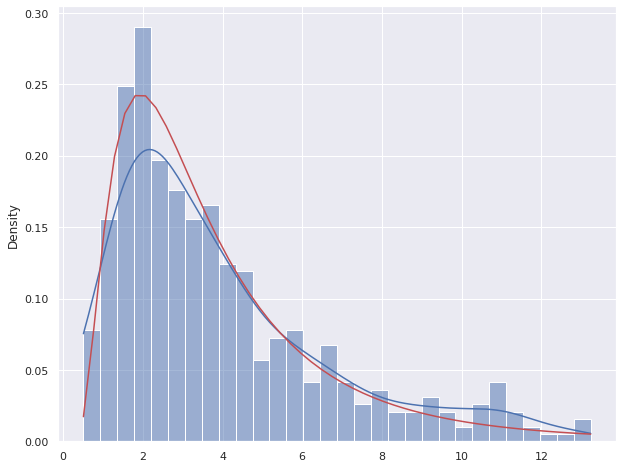

In [51]:
plt.figure(figsize=(10, 8))
sns.histplot(P_B_trimmed, kde=True, bins=30, stat='density', label=f'APrice/Book ratio')
x = np.linspace(np.min(P_B_trimmed), np.max(P_B_trimmed))
params_log = scipy.stats.lognorm.fit(P_B_trimmed)
print(f'{params_log}')
pdf = scipy.stats.lognorm.pdf(x, *params_log) 
plt.plot(x, pdf, 'r')
plt.show()

In [11]:
def lognorm_dist(x, a, sigma):
    exp = np.exp(-(np.log(x) - a)**2 / (2 * sigma ** 2))

    frac =  (x * sigma * (2 * np.pi) ** 0.5)
    return exp / frac

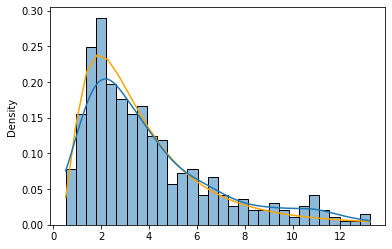

In [38]:
import scipy.optimize
from functools import partial
hist, bin_edges = np.histogram(P_B_trimmed, bins=30, density=True)

freq = [hist[i] for i in range(len(hist) - 1)]
positions = [(bin_edges[i] + bin_edges[i+1])/2  for i in range(len(hist) - 1)]
res, _ = scipy.optimize.curve_fit(lognorm_dist, positions, freq)

x = np.linspace(np.min(P_B_trimmed), np.max(P_B_trimmed), 30, dtype=np.float64)
t_dist = list(map(partial(lognorm_dist, a=res[0], sigma=res[1]), x))
plt.plot(x, t_dist, 'orange')
sns.histplot(P_B_trimmed, kde=True, bins=30, stat='density', label=f'Price/Book ratio')
plt.savefig('lqm.png')

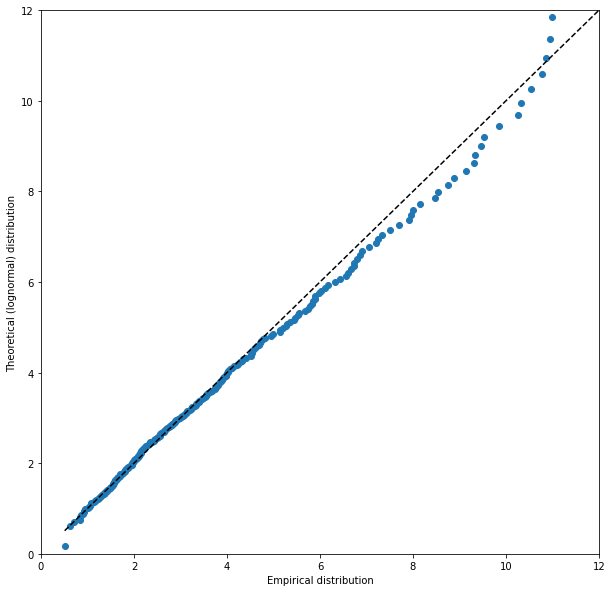

In [37]:
percs = np.linspace(0, 100, 250)
qn_first = np.percentile(P_B_trimmed, percs)
qn_norm = scipy.stats.lognorm.ppf(percs / 100.0, *params_log)
plt.figure(figsize=(10, 10))
plt.plot(qn_first, qn_norm, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlim(0, 12)
plt.ylim(0, 12)
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (lognormal) distribution')
plt.savefig('biplot2.png')

In [52]:
ks = scipy.stats.kstest(P_B_trimmed, 'lognorm', params_log, N=100)
ks

KstestResult(statistic=0.03029754054203926, pvalue=0.7859814719027028)